In [448]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm
import math

In [2]:
nlp = spacy.load('../data/models/spacy_model_250421/')

In [80]:
df = pd.read_parquet('../data/processed/RZ_processed.parquet')

### Create a second column for normalized headings

In [81]:
def normalize_headings(df):
    
    df['heading'] = df['heading'].str.strip('.')
    df['heading'] = df['heading'].str.strip(',')
    df['heading'] = df['heading'].str.strip(' ')
    df['heading'] = df['heading'].str.lstrip(' ')
    
    heading_replacement_dict = {
            'Witterungs-Beobachtungen in Riga': 'Witterungsbeobachtungen in Riga',
            'Witterungs- Beobachtungen in Riga': 'Witterungsbeobachtungen in Riga',
            'Meteorologische Beobachtungen in Riga': 'Witterungsbeobachtungen in Riga',
            'Witterungs- Beobachtungen in Riga': 'Witterungsbeobachtungen in Riga',
            'Witterungs -Beobachtungen in Riga': 'Witterungsbeobachtungen in Riga',
            'Witterunsbeobachtungen in Riga': 'Witterungsbeobachtnogen in Riga',
            'Groszbritannien und Irland': 'Großbritannien und Irland',
            'Grossbritannien und Irland': 'Großbritannien und Irland',
            'Grosbritannien und Irland': 'Großbritannien und Irland',
            'Todes – Anzeige': 'Todes-Anzeige',
            'Todes– Anzeige': 'Todes-Anzeige',
            'Todes-Anzeigen': 'Todes-Anzeige',
            'Todes – Anzeigen': 'Todes-Anzeige',
            'Telegraphische Nachrichten': 'Telegramme',
            'Lokales': 'Locales',
            'Börsen- und Handels – Nachrichten': 'Börsen- und Handels-Nachrichten',
            'Börsen – und Handels – Nachrichten': 'Börsen- und Handels-Nachrichten',
            'Börsen und Handels-Nackrichten': 'Börsen- und Handels-Nachrichten',
            'Börsen – und Handels – Nachrichten': 'Börsen- und Handels-Nachrichten',
            'Telegraphische Depesche der „Rigaschen Zeitung"': 'Telegramme der „Rigaschen Zeitung"',
            'Witterungs-Telegramme': 'Telegraphische Witterungsberichte',
            'Vermischte Nachrichten': 'Vermischtes',
            'Tägliche Eisenbahuzüge': 'Eisenbahnzüge',
            'Tägliche – Eisenbahnzüge': 'Eisenbahnzüge',
            'Telegr. Berichte über den Barometerstand': 'Telegraphische Witterungsberichte',
            'Inländische Nachrichten': 'Inland',
            'Inlandische Nachrichten': 'Inland',
            'Telegr. der Rig. Telegraphen Agentur': 'Telegramme',
            'Folgende Personen sind gesonnen, von hier zu reise': 'Abreisende',
            'Nachstehende Personen zeigen ihre Abreise von hier': 'Abreisende',
            'Tägliche – Eisenbahnzüge': 'Eisenbahnzüge',
            'Deutsches «eich': 'Deutsches Reich',
            'Neueste Rachrichten': 'Neueste Nachrichten',
            'Neuste Nachrichten': 'Neueste Nachrichten',
                }
    
    df['heading'] = df['heading'].replace(to_replace=heading_replacement_dict)
    
    return df

In [82]:
df = normalize_headings(df)

In [7]:
def get_loc_heading_dict(df, nlp_model, ignorelocs=[]):
    
    loc_replacements = {}
    headings = df.heading.unique()
    
    for i in tqdm(range(0, len(headings))):
        title = df.loc[i, 'heading']
        doc = nlp(title)
        locs = [ent.text for ent in doc.ents if ent.label_ == 'LOC']
        if len(locs) == 1:
            if locs[0] not in ignorelocs:
                loc_replacements[title] = locs[0]

    return loc_replacements

In [38]:
loc_heading_dict = get_loc_heading_dict(df, nlp)

100%|██████████████████████████████████████████████████████████████████████████| 149969/149969 [28:28<00:00, 87.77it/s]


In [39]:
import json

with open('../pipeline/01_data/loc_heading_dict.json', 'w', encoding='utf8') as f:
    json_string = json.dumps(loc_heading_dict)
    f.write(json_string)  

In [8]:
import json

with open('../pipeline/01_data/loc_heading_dict.json', 'r', encoding='utf8') as f:
    json_string = f.read()
    loc_heading_dict = json.loads(json_string) 

In [740]:
def generate_alt_headings(df, ignorelocs):
    
    df['heading2'] = df['heading']
    
    for i in tqdm(df.index):
        title = df.loc[i, 'heading2']
        doc = nlp(title)
        locs = [ent.text for ent in doc.ents if ent.label_ == 'LOC']
        if len(locs) == 1:
            if locs[0] not in ignorelocs:
                df.loc[i, 'heading2'] = locs[0]
    
    return df['heading2']

In [44]:
df = generate_alt_headings(df, ['Riga', 'Rigasche', 'Rigaschen', 'Rigische'])

100%|████████████████████████████████████████████████████████████████████████| 289705/289705 [1:46:33<00:00, 45.31it/s]


In [46]:
df.heading2.to_csv('../data/processed/RZ_heading2.tsv', sep='\t', encoding='utf8', index=False)

In [102]:
def add_second_heading(df):
    
    heading2 = pd.read_csv('../data/processed/RZ_heading2.tsv', sep='\t', encoding='utf8')
    df['heading2'] = heading2
    
    df['heading_loc'] = False
    df.loc[df.heading != df.heading2, 'heading_loc'] = True
    
    loc_replacement_dict = {'Pari': 'Paris',
                        'Petersburg': 'St. Petersburg',
                        'St. Petersb.': 'St. Petersburg',
                        'PariS': 'Paris',
                        'Newyork': 'New York',
                        'New-York': 'New York',
                        'X London': 'London'}
    
    df['heading2'] = df['heading2'].replace(to_replace=loc_replacement_dict)
    
    return df

In [103]:
df = add_second_heading(df)

In [104]:
top_headings = list(df.heading2.value_counts()[0:50].index)

with open('../pipeline/01_data/top_headings.json', 'w', encoding='utf8') as f:
    json_string = json.dumps(top_headings)
    f.write(json_string)

## Geographical representation

In [193]:
def load_places(cities_minpop):
                   
    countries = pd.read_csv('../data/processed/geonames/countries150721.tsv', sep='\t', encoding='utf8').convert_dtypes()
    cities = pd.read_csv('../data/processed/geonames/cities150721.tsv', sep='\t', encoding='utf8').convert_dtypes()
    cities = cities[(cities.feature_code == 'PPLC')|(cities.population >= cities_minpop)]
    regions = pd.read_csv('../data/processed/geonames/regions280721.tsv', sep='\t', encoding='utf8').convert_dtypes()
                   
    places = pd.concat([countries, cities, regions])
    places.name = ',' + places.name + ',' + places.alternatenames + ','
    places = places[['geonameid', 'name', 'y', 'x', 'population']]
    places = places.rename(columns={'name': 'names'})
                   
    return places

In [194]:
places = load_places(30000)

In [390]:
def get_geodata(df, places, year):
    
    headings = df.heading2[(df.year == year) & (df.heading_loc == True)]
    headings = headings.value_counts().reset_index(name='count')
    headings = headings[headings['count'] > 1]
    headings = headings.rename(columns={'index': 'name'})
    
    headings['x'] = np.nan
    headings['y'] = np.nan
    
    notfound = []
    
    for name in headings.name:
        match = places[places.names.str.contains(','+name+',')]
        if len(match) == 1:
            headings.loc[headings.name == name, 'x'] = match.x.values
            headings.loc[headings.name == name, 'y'] = match.y.values
        elif len(match) > 1:
            match = match[match.population == max(match.population)]
            if len(match) == 1:
                headings.loc[headings.name == name, 'x'] = match.x.values
                headings.loc[headings.name == name, 'y'] = match.y.values
            else:
                match = match.sample(1)
                headings.loc[headings.name == name, 'x'] = match.x.values
                headings.loc[headings.name == name, 'y'] = match.y.values
        elif len(match) == 0:
            notfound.append(name)
            
    headings.dropna(0, 'any', inplace=True)
                        
    return headings.to_dict()

In [402]:
places_by_year = {}

for i in tqdm(range(1802,1889)):
    places_by_year[i] = get_geodata(df, places, i)
    
with open('../pipeline/01_data/headings_places.json', 'w', encoding='utf8') as f:
    json_string = json.dumps(places_by_year)
    f.write(json_string)

100%|██████████████████████████████████████████████████████████████████████████████████| 87/87 [03:20<00:00,  2.30s/it]


In [427]:
def generate_map(year):

    m = folium.Map(location=[50, 15],
                   zoom_start=4,
                   tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/tile/{z}/{y}/{x}',
                   attr='Tiles &copy; Esri &mdash; Source: US National Park Service')

    location_data = places_by_year[year]
    
    for i in location_data['name'].keys():
    
        x = location_data['x'][i]
        y = location_data['y'][i]
        name = location_data['name'][i]
        count = location_data['count'][i]
        size = count*1000
        
        folium.Circle(location=[y, x],
                    popup=f'{name}: {count}',
                    radius=size,
                    color="#3186cc",
                    fill=True,
                    fill_color="#3186cc").add_to(m)
    
    return (m)

In [735]:
def generate_map_from_timerange(timerange, places_by_year):

    m = folium.Map(location=[50, 15],
                   zoom_start=4,
                   tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Physical_Map/MapServer/tile/{z}/{y}/{x}',
                   attr='Tiles &copy; Esri &mdash; Source: US National Park Service')
    
    places_in_timerange = {}
    
    for year in timerange:

        year_data = places_by_year[year]
        max_count = 0
        
        for i, j in zip(year_data['name'].keys(), year_data['name'].values()):
            
            placename = j
            x = year_data['x'][i]
            y = year_data['y'][i]
            count = year_data['count'][i]
            
            if placename in places_in_timerange.keys():
                places_in_timerange[j]['count'] += count
                if places_in_timerange[j]['count'] > max_count:
                    max_count = places_in_timerange[j]['count']
                
            else:
                places_in_timerange[j] = {'x': x,
                                          'y': y,
                                          'count': count}
                
    for place in places_in_timerange.keys():
        
        location_data = places_in_timerange[place]
        
        x = location_data['x']
        y = location_data['y']
        count = location_data['count']
        size = count*(max_count/len(timerange))+10000
        
        folium.Circle(location=[y, x],
                    popup=f'{place}: {count}',
                    radius=size,
                    color="#3186cc",
                    fill=True,
                    fill_color="#3186cc").add_to(m)
    
    print(max_count/len(timerange))
    
    return (m)

generate_map_from_timerange(range(1860,1880), places_by_year)

108.05


### Explore the relative importance of headings

In [741]:
top_headings = list(df['heading2'].value_counts()[0:50].index)

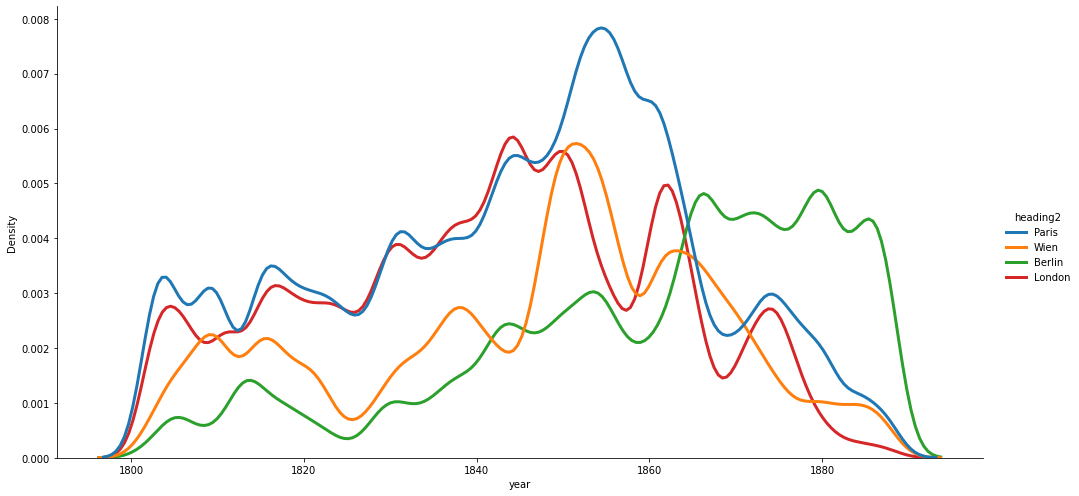

In [743]:
def create_headings_df():
    headings_df = df[df['heading2'].isin(top_headings)]
    headings_df = df[['year', 'heading2']]
    return headings_df

headings_df = create_headings_df()
heading_options = ['Paris', 'London', 'Berlin', 'Wien']
headings_plot_df = headings_df[headings_df['heading2'].isin(heading_options)]
headings_plot = sns.displot(headings_plot_df, x="year", hue="heading2", kind="kde", height=7, aspect=2, bw_adjust=.5, linewidth=3)

plt.show(headings_plot)

In [1009]:
def create_headings_df(df):
    
    headings_df = df[df['heading2'].isin(top_headings)]
    headings_df = headings_df[['year', 'heading2']]
    headings_df = headings_df.groupby(['year', 'heading2'])['heading2'].agg('count').unstack(fill_value=0).stack().reset_index(name='count')
    
    headings_df['weight'] = 0

    for i in tqdm(range(0,len(headings_df))):
        year = headings_df.loc[i, 'year']
        count = headings_df.loc[i, 'count']
        weight = count / len(df[df.year==year])
        headings_df.loc[i, 'weight'] = weight
        
    return headings_df

In [1010]:
headings_df = create_headings_df(df)

100%|█████████████████████████████████████████████████████████████████████████████| 4300/4300 [00:18<00:00, 230.11it/s]


In [1018]:
headings_df.to_csv('../climdist/streamlit/streamlit_rz/headings_df.tsv', sep='\t', encoding='utf8', index=False)

In [1028]:
loaded_headings_df = pd.read_csv('../climdist/streamlit/streamlit_rz/headings_df.tsv', sep='\t', encoding='utf8')

In [1029]:
headings_plot_df = headings_df[['year', 'heading2', 'weight']][headings_df.heading2.isin(['Paris', 'Berlin', 'London'])].copy()

In [1030]:
pt = headings_plot_df.pivot_table(index='year', columns='heading2')

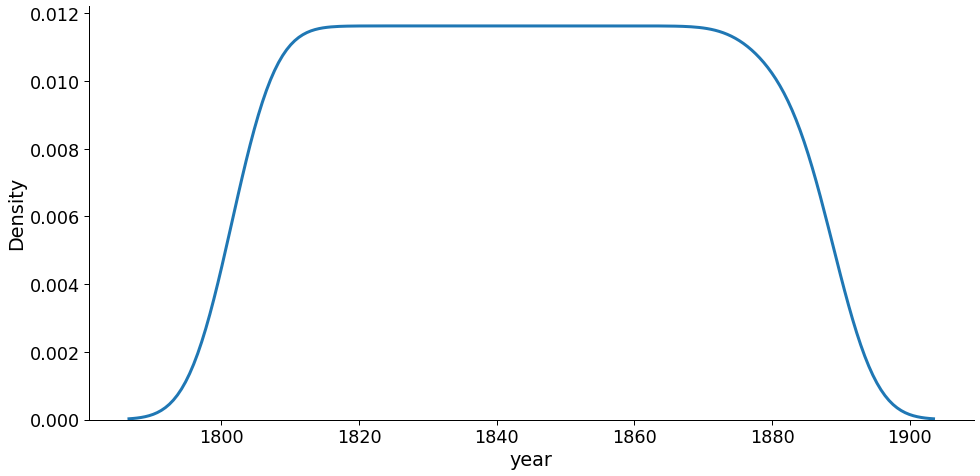

In [1033]:
sns.displot(data=pt, x='year', kind='kde', height=7, aspect=2, bw_adjust=.5, linewidth=3)
plt.show()

In [990]:
pt['weight'].columns

Index(['Berlin', 'London', 'Paris'], dtype='object', name='heading2')

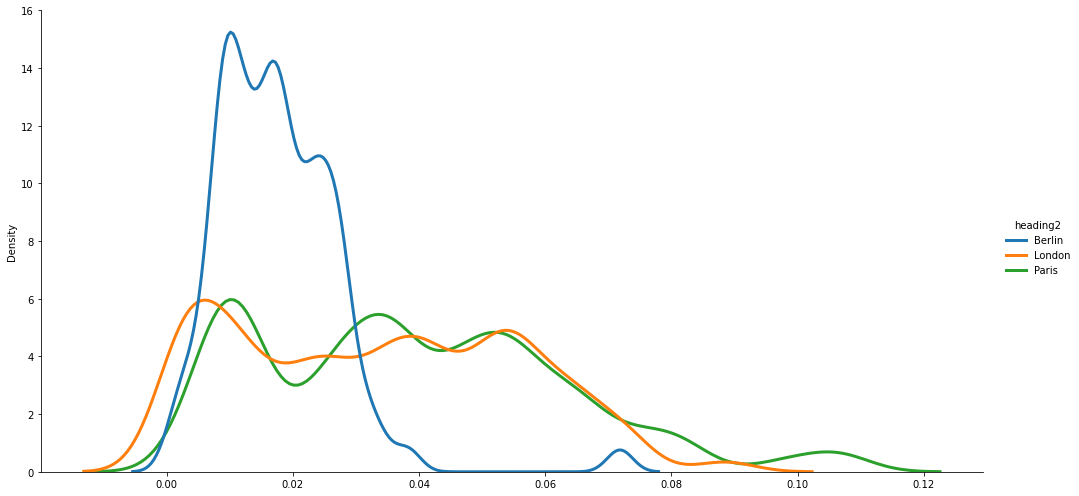

In [995]:
sns.displot(data=pt['weight'], kind='kde', height=7, aspect=2, bw_adjust=.5, linewidth=3)

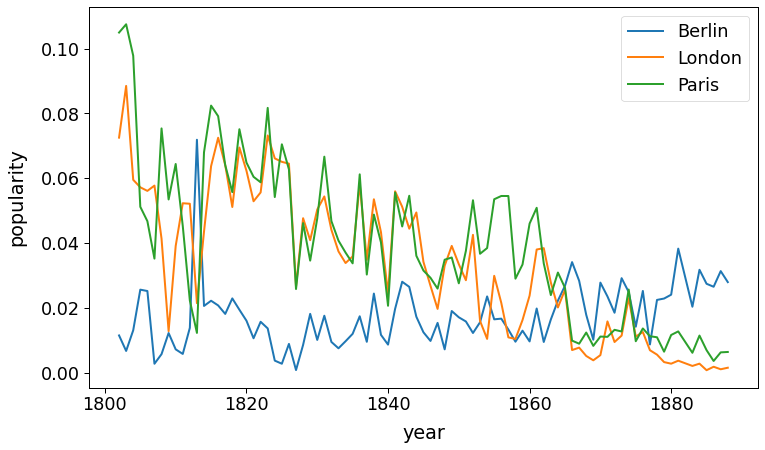

In [1048]:

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot()
plot = pt['weight'].plot(ax=ax, linewidth=2)
plot.legend()
ax.set_xlabel('year', labelpad=10)
ax.set_ylabel('popularity', labelpad=15)
plt.show(plot)

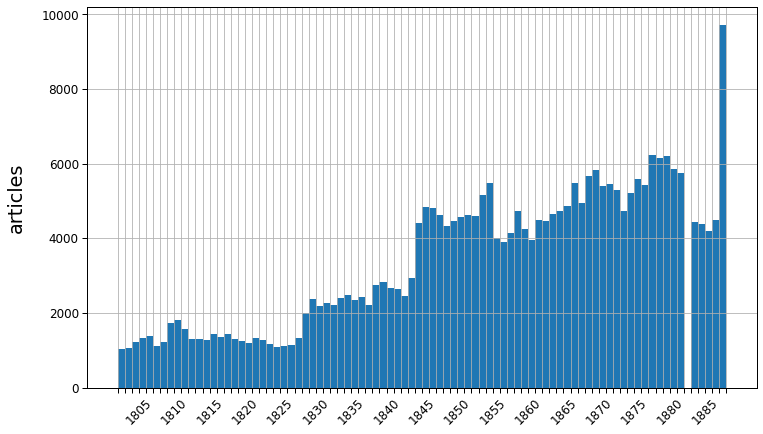

In [1087]:
ticksrange = np.arange(1802,1889)
xlabels = [num if num%5==0 else '' for num in np.arange(1802,1889)]

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot()
plot = df.year.hist(bins=86)
ax.set_ylabel('articles', labelpad=15)
#plt.grid(b=True, which='both')
ax.grid(b=True, axis='x')
plt.xticks(ticks=ticksrange, labels=xlabels)
plt.tick_params(axis ='x', rotation = 45, labelsize=12)
plt.tick_params(axis ='y', labelsize=12)

plt.savefig('../climdist/streamlit/streamlit_rz/data_histogram.png', bbox_inches='tight')

plt.show(fig)

In [ ]:
sns.displot(headings_plot_df, x="year", hue="heading2", height=7, aspect=2)

In [24]:
headings = ['Deutschland', 'Telegramme', 'Inland']

headings_df = df[['year', 'heading']]
headings_df = headings_df[headings_df['heading'].isin(headings)]

headings_df_agg = headings_df.groupby(['year', 'heading'])['heading'].agg('count').unstack(fill_value=0).stack().reset_index(name='count')
headings_table = pd.pivot_table(data=headings_df_agg, index=['year', 'heading'], values='count', aggfunc='sum', fill_value=0)
headings_table = headings_table.reset_index()

<AxesSubplot:xlabel='year', ylabel='count'>

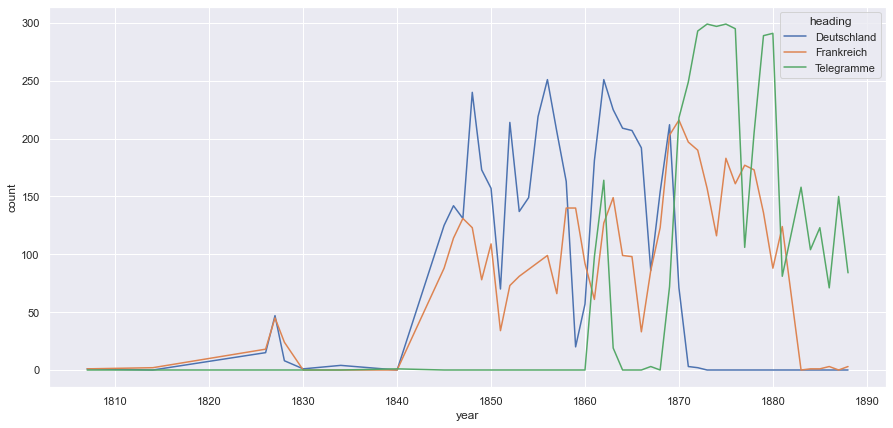

In [196]:
sns.lineplot(data=headings_table, x='year', y='count', hue='heading')

<AxesSubplot:xlabel='year', ylabel='Count'>

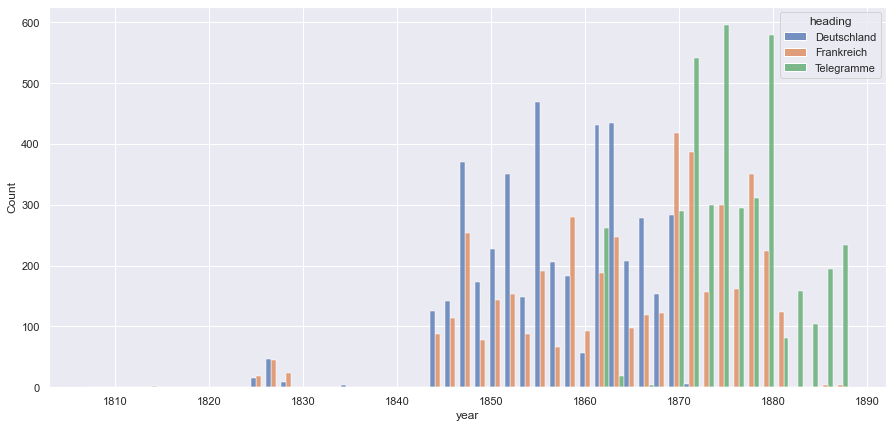

In [227]:
sns.histplot(data=headings_df, x='year', hue='heading', multiple='dodge', bins=51)

In [47]:
df.groupby('year')['year'].count()

year
1802    1048
1803    1051
1804    1227
1805    1329
1806    1391
        ... 
1884    4382
1885    4197
1886    4494
1887    4982
1888    4729
Name: year, Length: 86, dtype: int64

In [52]:
df[(df.year==1802)]

,date,year,month,day,pub,heading,full_text,href,text_len,w_count
0,1802-01-01,1802,1,1,Rigasche Zeitung,"St. Petersburg, den 20. Decemb","St. Petersburg, den 20. Decemb.\n\n\tAuf Aller...",https://proc.dom.lndb.lv/file.axd?id=3377815&a...,2067,260
1,1802-01-01,1802,1,1,Rigasche Zeitung,"Paris, den 18ten December","Paris, den 18ten December.\n\n\tDer Oberconsu!...",https://proc.dom.lndb.lv/file.axd?id=3377818&a...,3664,534
2,1802-01-01,1802,1,1,Rigasche Zeitung,"Haag, den 22sten December","Haag, den 22sten December.\n\n\tIn kurzem erwa...",https://proc.dom.lndb.lv/file.axd?id=3377819&a...,967,135
3,1802-01-01,1802,1,1,Rigasche Zeitung,"Zürich, den 16ten December","Zürich, den 16ten December.\n\n\tDie durch die...",https://proc.dom.lndb.lv/file.axd?id=3377822&a...,482,65
4,1802-01-01,1802,1,1,Rigasche Zeitung,"Wien, den 19ten December","Wien, den 19ten December.\n\n\tDie Malcheser-N...",https://proc.dom.lndb.lv/file.axd?id=3377823&a...,1154,170
...,...,...,...,...,...,...,...,...,...,...
1043,1802-12-31,1802,12,31,Rigasche Zeitung,"Wien, den 18. Dec","Wien, den 18. Dec.\n\n\tDieser Tage ereignete ...",https://proc.dom.lndb.lv/file.axd?id=13107785&...,629,96
1044,1802-12-31,1802,12,31,Rigasche Zeitung,"Fiume, den 23. November","Fiume, den 23. November.\n\n\tVor drey Tagen i...",https://proc.dom.lndb.lv/file.axd?id=13107786&...,486,76
1045,1802-12-31,1802,12,31,Rigasche Zeitung,"Copenhagen, den 25. Dec","Copenhagen, den 25. Dec.\n\n\tMit der letzten ...",https://proc.dom.lndb.lv/file.axd?id=13107787&...,640,96
1046,1802-12-31,1802,12,31,Rigasche Zeitung,Angekommene Fremde,Angekommene Fremde.\n\n\tDen 25. December.\nHe...,https://proc.dom.lndb.lv/file.axd?id=13107788&...,2568,352


In [40]:
df[df.year == 1802]

,date,year,month,day,pub,heading,full_text,href,text_len,w_count
0,1802-01-01,1802,1,1,Rigasche Zeitung,"St. Petersburg, den 20. Decemb","St. Petersburg, den 20. Decemb.\n\n\tAuf Aller...",https://proc.dom.lndb.lv/file.axd?id=3377815&a...,2067,260
1,1802-01-01,1802,1,1,Rigasche Zeitung,"Paris, den 18ten December","Paris, den 18ten December.\n\n\tDer Oberconsu!...",https://proc.dom.lndb.lv/file.axd?id=3377818&a...,3664,534
2,1802-01-01,1802,1,1,Rigasche Zeitung,"Haag, den 22sten December","Haag, den 22sten December.\n\n\tIn kurzem erwa...",https://proc.dom.lndb.lv/file.axd?id=3377819&a...,967,135
3,1802-01-01,1802,1,1,Rigasche Zeitung,"Zürich, den 16ten December","Zürich, den 16ten December.\n\n\tDie durch die...",https://proc.dom.lndb.lv/file.axd?id=3377822&a...,482,65
4,1802-01-01,1802,1,1,Rigasche Zeitung,"Wien, den 19ten December","Wien, den 19ten December.\n\n\tDie Malcheser-N...",https://proc.dom.lndb.lv/file.axd?id=3377823&a...,1154,170
...,...,...,...,...,...,...,...,...,...,...
1043,1802-12-31,1802,12,31,Rigasche Zeitung,"Wien, den 18. Dec","Wien, den 18. Dec.\n\n\tDieser Tage ereignete ...",https://proc.dom.lndb.lv/file.axd?id=13107785&...,629,96
1044,1802-12-31,1802,12,31,Rigasche Zeitung,"Fiume, den 23. November","Fiume, den 23. November.\n\n\tVor drey Tagen i...",https://proc.dom.lndb.lv/file.axd?id=13107786&...,486,76
1045,1802-12-31,1802,12,31,Rigasche Zeitung,"Copenhagen, den 25. Dec","Copenhagen, den 25. Dec.\n\n\tMit der letzten ...",https://proc.dom.lndb.lv/file.axd?id=13107787&...,640,96
1046,1802-12-31,1802,12,31,Rigasche Zeitung,Angekommene Fremde,Angekommene Fremde.\n\n\tDen 25. December.\nHe...,https://proc.dom.lndb.lv/file.axd?id=13107788&...,2568,352


In [208]:
penguins = sns.load_dataset('penguins')

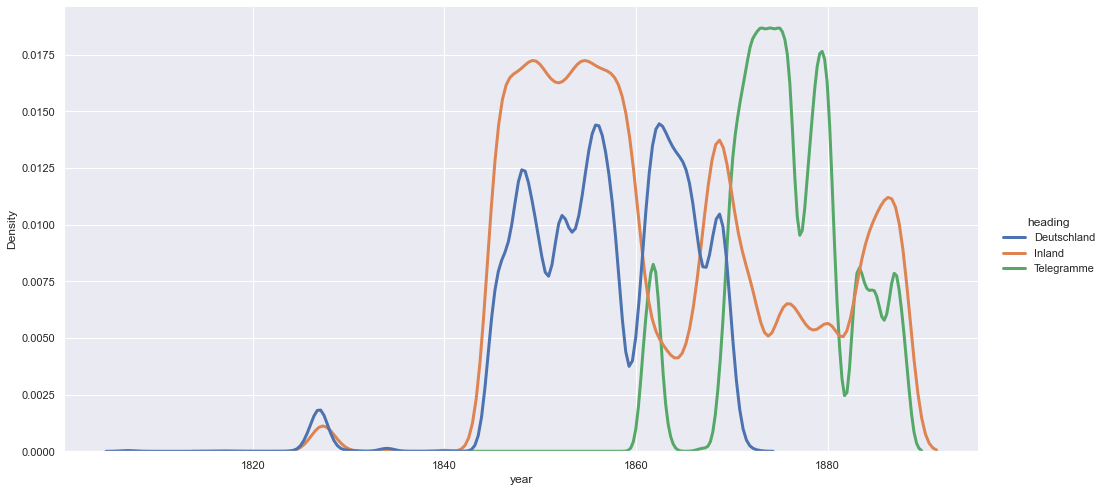

In [237]:
sns.set_style('darkgrid')
sns.displot(headings_df, x="year", hue="heading", kind="kde", height=7, aspect=2, bw_adjust=.5, linewidth=3)

In [5]:
df[df.year<1840].heading.value_counts()[0:50]

Angekommene Fremde                                    2950
Vermischtes                                           1943
Bekanntmachung                                        1642
Bekanntmachungen                                      1522
Todes-Anzeige                                          776
Folgende Personen sind gesonnen von hier zu reisen     356
Auktion                                                234
Polnische Lotterie                                     201
Ist zu drucken erlaubt. Im Namen der Civil-Oberver     155
Abreisende                                             131
Portugal                                               120
Türkei                                                 118
Spanische Angelegenheiten                              116
Spanien                                                102
Zu verkaufen                                           102
Frankreich                                              90
England                                                 

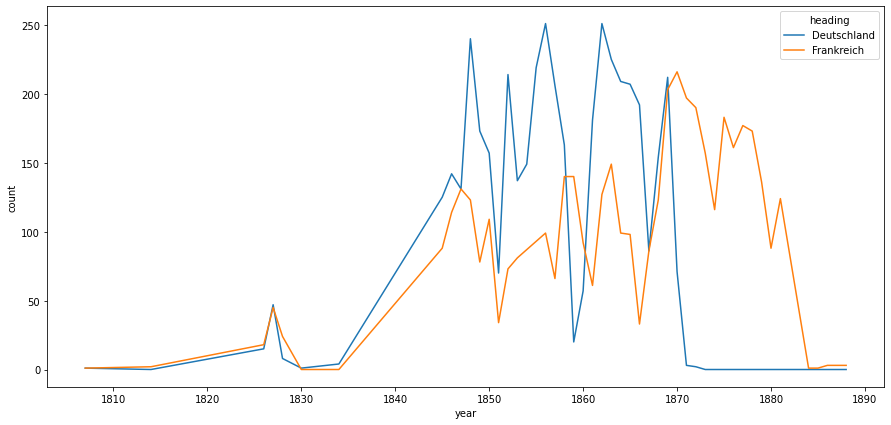

In [126]:
plt.figure(figsize=(15,7))
sns.lineplot(data=headings_df_agg, x='year', y='count', hue='heading')
plt.show()

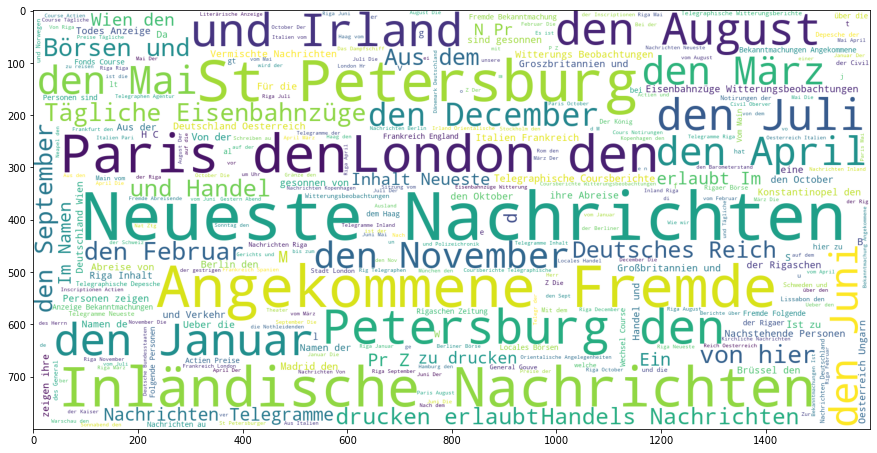

In [38]:
from wordcloud import WordCloud

wordcloud_text = ''
for entry in df['head'].str.strip('.'):
    wordcloud_text += entry
    wordcloud_text += '\n'

wordcloud = WordCloud(background_color="white",
                      width=1600,
                      height=800,
                      max_words=300,
                      contour_width=3,
                      contour_color='firebrick').generate(wordcloud_text)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)

plt.show()

In [52]:
max(df.year)

1888

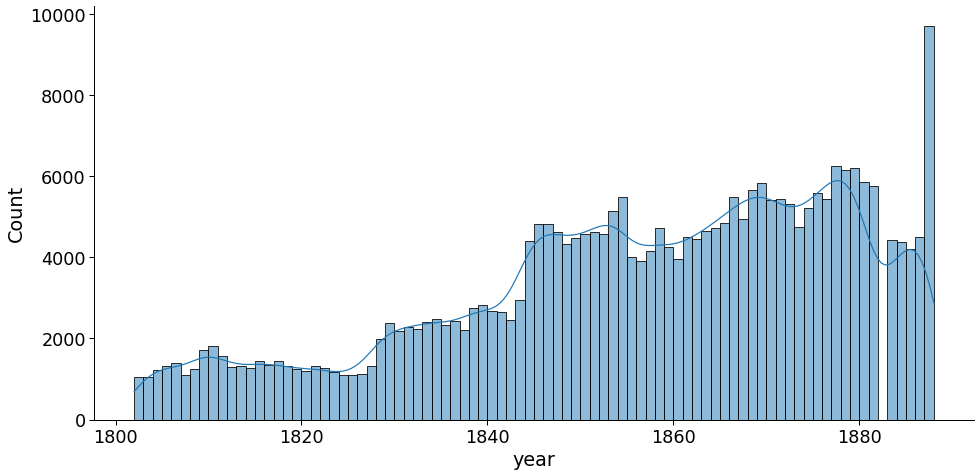

In [1013]:
sns.set_context('paper', font_scale=2)
ch_articles_per_year = sns.displot(df.year,
                                bins=86,
                                height=7,
                                aspect=2,
                                kde=True)


plt.show(ch_articles_per_year)